In [ ]:
!pip install matplotlib
!pip install transformers

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import requests
from PIL import Image
from io import BytesIO
import base64
import torch
import torch.nn.functional as F

from transformers import Qwen2_5_VLProcessor, Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from transformers.models.qwen2_vl.image_processing_qwen2_vl_fast import smart_resize


/home/tiger/anaconda3/envs/gui/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def convert_pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()


def get_qwen2_5vl_prompt_msg(image, instruction, screen_width, screen_height):
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": 3136,
                    "max_pixels": 12845056,
                    "image_url": {
                        "url": "data:image/png;base64," + convert_pil_image_to_base64(image)
                    }
                },
                {
                    "type": "text",
                    "text": instruction
                }
            ]
        }
    ]


In [5]:
# ===> specify the model path
model_name_or_path = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name_or_path, 
    device_map="cuda", 
    torch_dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2" # Do not use flash-attn or getting attention scores will fail!
).eval()

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_name_or_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


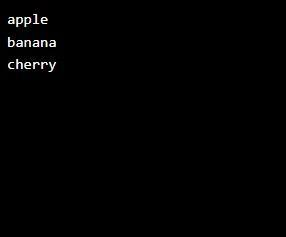

In [6]:
image_path_or_url = "https://github.com/open-compass/MMBench/blob/main/samples/MMBench/1.jpg?raw=true"
prompt_text = "What python code can be used to generate the output in the image?"

image = Image.open(requests.get(image_path_or_url, stream=True).raw)
image

In [7]:
# generate the response

resized_height, resized_width = smart_resize(
    image.height,
    image.width,
    factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
    min_pixels=processor.image_processor.min_pixels,
    max_pixels=processor.image_processor.max_pixels,
)

messages = get_qwen2_5vl_prompt_msg(image, prompt_text, resized_width, resized_height)
# Preparation for inference
text_input = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
inputs = processor(
    text=[text_input],
    images=[image],
    padding=True,
    return_tensors="pt",
).to("cuda")
outputs = model.generate(
    **inputs, 
    max_new_tokens=512, 
    return_dict_in_generate=True,
    output_attentions=True,
)
decoded_text = processor.batch_decode(
    outputs["sequences"], skip_special_tokens=False, clean_up_tokenization_spaces=False
)[0]
print("Generated text: ", decoded_text)

Qwen2_5_VLModel is using Qwen2_5_VLSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Generated text:  <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_

In [8]:
outputs.keys()

odict_keys(['sequences', 'attentions', 'past_key_values'])

In [9]:
outputs.keys()

odict_keys(['sequences', 'attentions', 'past_key_values'])

In [10]:
len(outputs['attentions'])  # (step?, layer, (bs, num_heads, seq_len, seq_len))

86

In [11]:
len(outputs['attentions'][0])  # 36 layers

36

In [12]:
outputs['attentions'][0][30].shape  # (bs, num_heads, seq_len(this step), seq_len(previous all))

torch.Size([1, 16, 115, 115])

Below we are aggregating LLM's attention aross heads and layers (simply averaging them).

In [21]:
# many are copied from https://github.com/mattneary/attention/blob/master/attention/attention.py
# here it nullifies the attention over the first token (<bos>)
# which in practice we find to be a good idea
from io import BytesIO
from PIL import Image
import requests
import torch
import numpy as np
import cv2


def aggregate_llm_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:].cpu(),
            # attns_per_head[-1].cpu(),
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)


def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0])))
        for v in vecs
    ])


def load_image(image_path_or_url):
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path_or_url).convert('RGB')
    return image


In [13]:
# constructing the llm attention matrix
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):  # step 0
    layer_attns = layer.squeeze(0)  # (num_heads, seq_len(this step), seq_len(previous all))
    attns_per_head = layer_attns.mean(dim=0)  # (seq_len(this step), seq_len(previous all))
    # cur = attns_per_head[:-1].cpu().clone()  # Why [:-1]? 
    cur = attns_per_head.cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention) 
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)

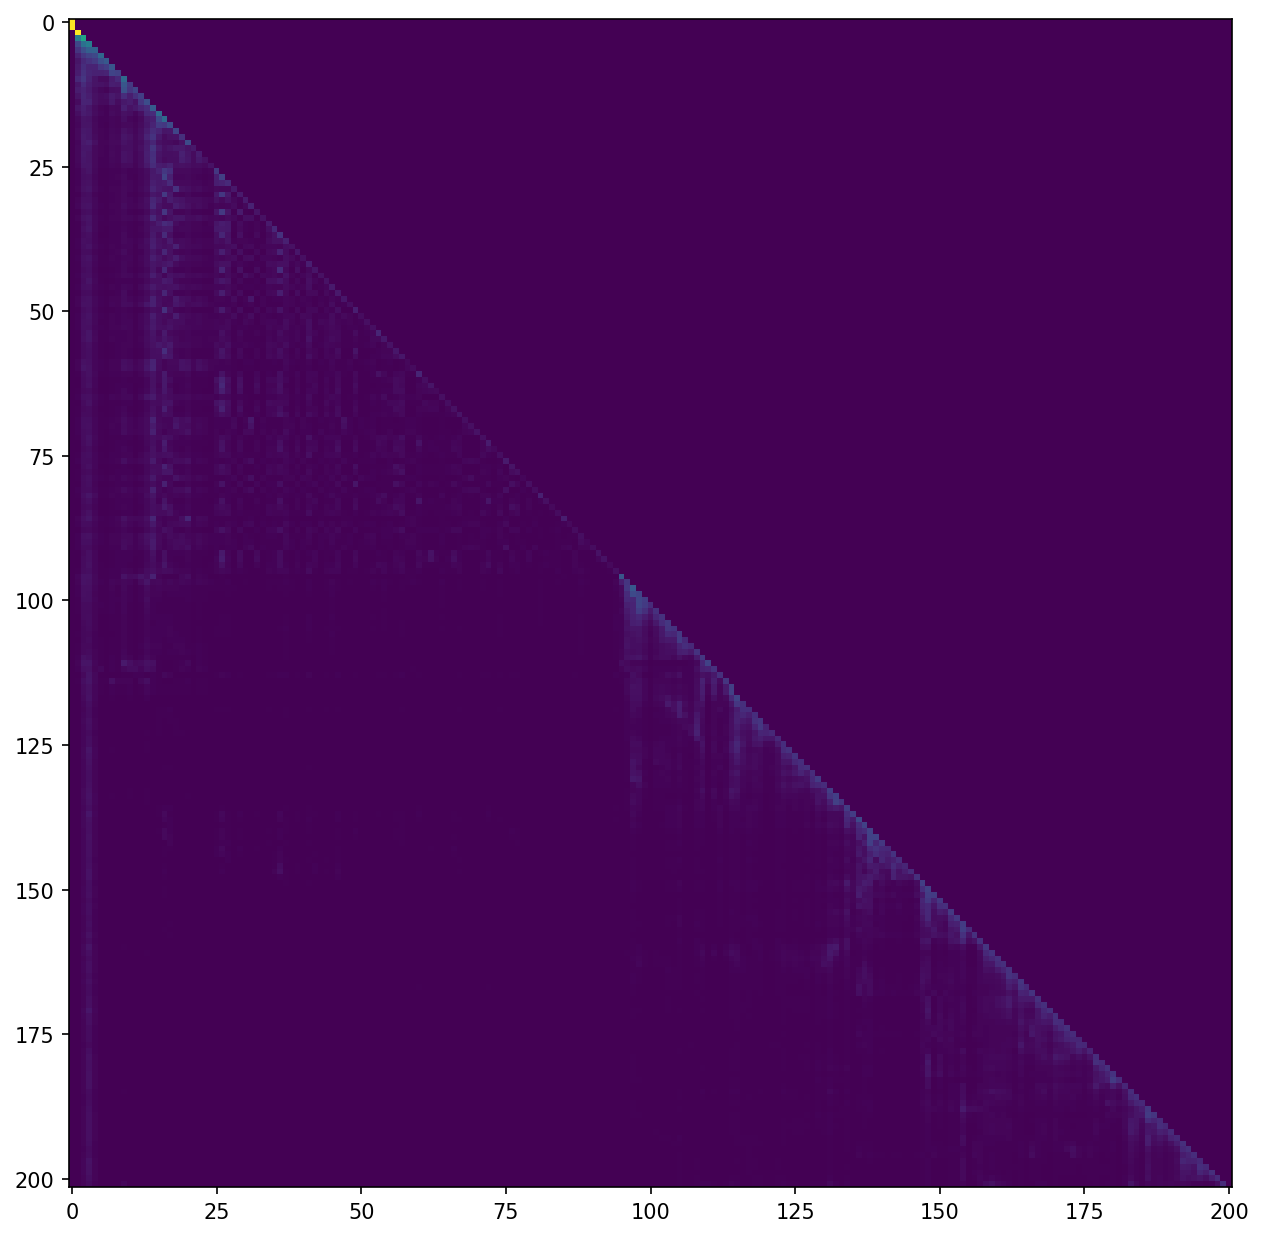

In [14]:
# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 1
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

In [15]:
# identify length or index of tokens
len_prompt_tokens = len(inputs.input_ids[0])
len_all_tokens = len(outputs["sequences"][0])

# The <|vision_start|> and <|vision_end|> are kept in the tokenized input, thus the +1
vision_token_start = len(tokenizer(decoded_text.split("<|vision_start|>")[0], return_tensors='pt')["input_ids"][0]) + 1
vision_token_end = len(tokenizer(decoded_text.split("<|vision_end|>")[0], return_tensors='pt')["input_ids"][0])
output_token_start = len_prompt_tokens
output_token_end = len_all_tokens
output_token_len = output_token_end - output_token_start

In [16]:
def get_token_img_shape(image_size, patch_size=28):
    """
    Calulate the shape of the token representation of the image, e.g. an image of (286, 237) is mapped to a (10, 8) token array.
    Qwen2.5VL uses ViT of patch size 14, plus a merger of 2*2 tokens, resulting in an equivalent of 28*28 tokens.
    """
    return image_size[0] // patch_size, image_size[1] // patch_size
print("Num of prompt tokens:", len(llm_attn_matrix[len_prompt_tokens:]))
token_shape = get_token_img_shape(image.size, patch_size=28)
print(f"Num of image tokens: {token_shape[0]} per row * {token_shape[1]} per colomn =", vision_token_end - vision_token_start)
print("Num of all tokens (prompt + generated):", len(outputs["sequences"][0].tolist()))

Num of prompt tokens: 87
Num of image tokens: 10 per row * 8 per colomn = 80
Num of all tokens (prompt + generated): 201


Text(0.5, 1.0, 'at each token, the sum of attention weights over all the vision tokens')

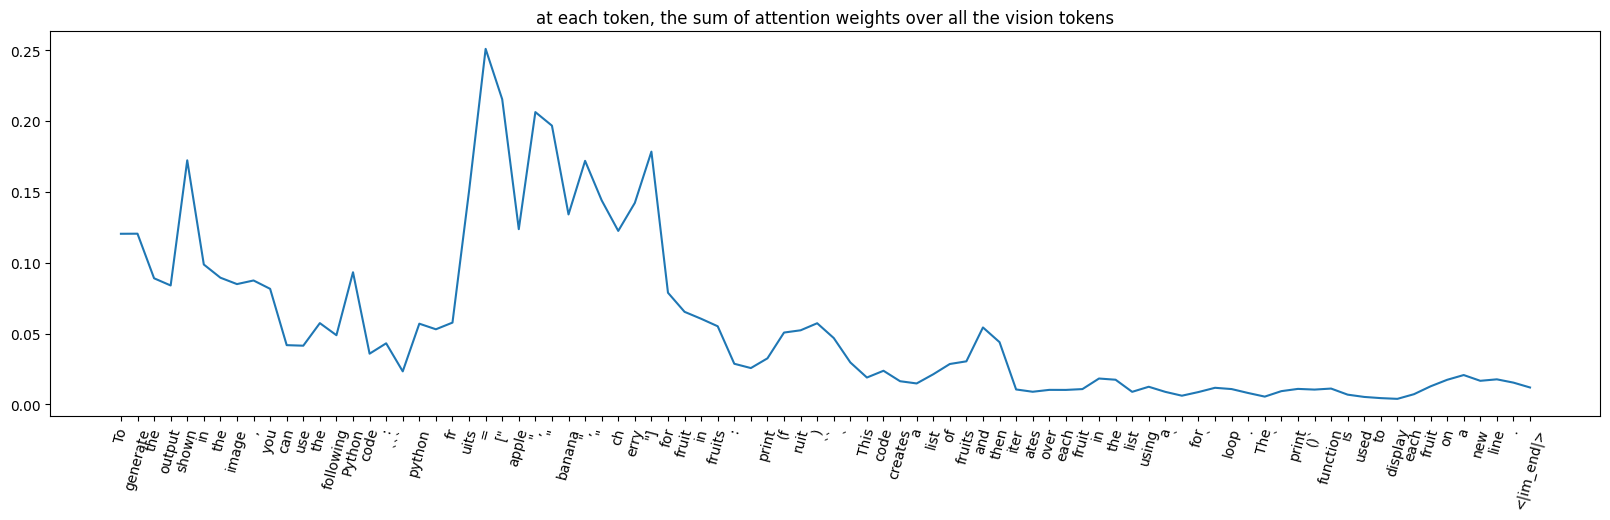

In [17]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[len_prompt_tokens:], 
        outputs["sequences"][0][len_prompt_tokens:].tolist()
    )
):
    # print(
    #     i + len_prompt_tokens, 
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}", 
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in outputs["sequences"][0][len_prompt_tokens:].tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens")

Below we aim to visualize the attention w.r.t. the input image. First we obtain a single attention map from the vision encoder (ViT) by again averaging the attention maps across heads and layers. I have tried a supposedly more reasonable method of [attention rollout](https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py), i.e. multiplying the attention matrices over each layer, but never got sensible results. See the `aggregate_vit_attention` in `utils.py` for details.


Then, for each generated token of LLM, we compute the weighted average of the attention map of each vision token to get an aggregated attention map over the input image for that generated token. Finally we resize and overlay the attention map on the input image.

In [18]:
output_token_len

86

In [46]:
# Defines how to lay the mask over the image.

# COLORMAP + alpha
# def show_mask_on_image(img, mask, alpha=0.3):
#     img = np.float32(img) / 255.0
#     heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_OCEAN)
#     heatmap = np.float32(heatmap) / 255.0
#     overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
#     return np.uint8(255 * overlay), np.uint8(255 * heatmap)


# Alpha
# def show_mask_on_image(img, mask, base_alpha=0.3):
#     img = np.float32(img) / 255.0
#     heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_OCEAN)
#     heatmap = np.float32(heatmap) / 255.0
#     overlay = heatmap * base_alpha + img * np.expand_dims(mask, -1) * (1 - base_alpha)
#     return np.uint8(255 * overlay), np.uint8(255 * heatmap)

# Blue to Red

def show_mask_on_image(img, mask, alpha=0.3):
    # Normalize image to 0-1
    img = np.float32(img) / 255.0
    
    # Create blue-to-red map from the mask (low values blue, high values red)
    blue_to_red_map = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    # Blue for low values, Red for high values
    blue_to_red_map[..., 0] = (255 * mask).astype(np.uint8)  # Blue channel (low values)
    blue_to_red_map[..., 2] = (255 * (1 - mask)).astype(np.uint8)  # Red channel (high values)
    
    # Convert to float for proper blending
    heatmap = np.float32(blue_to_red_map) / 255.0
    
    # Apply the overlay with blending
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    
    # Return the final image and heatmap (scaled back to 0-255 range)
    return np.uint8(255 * overlay), np.uint8(255 * heatmap)

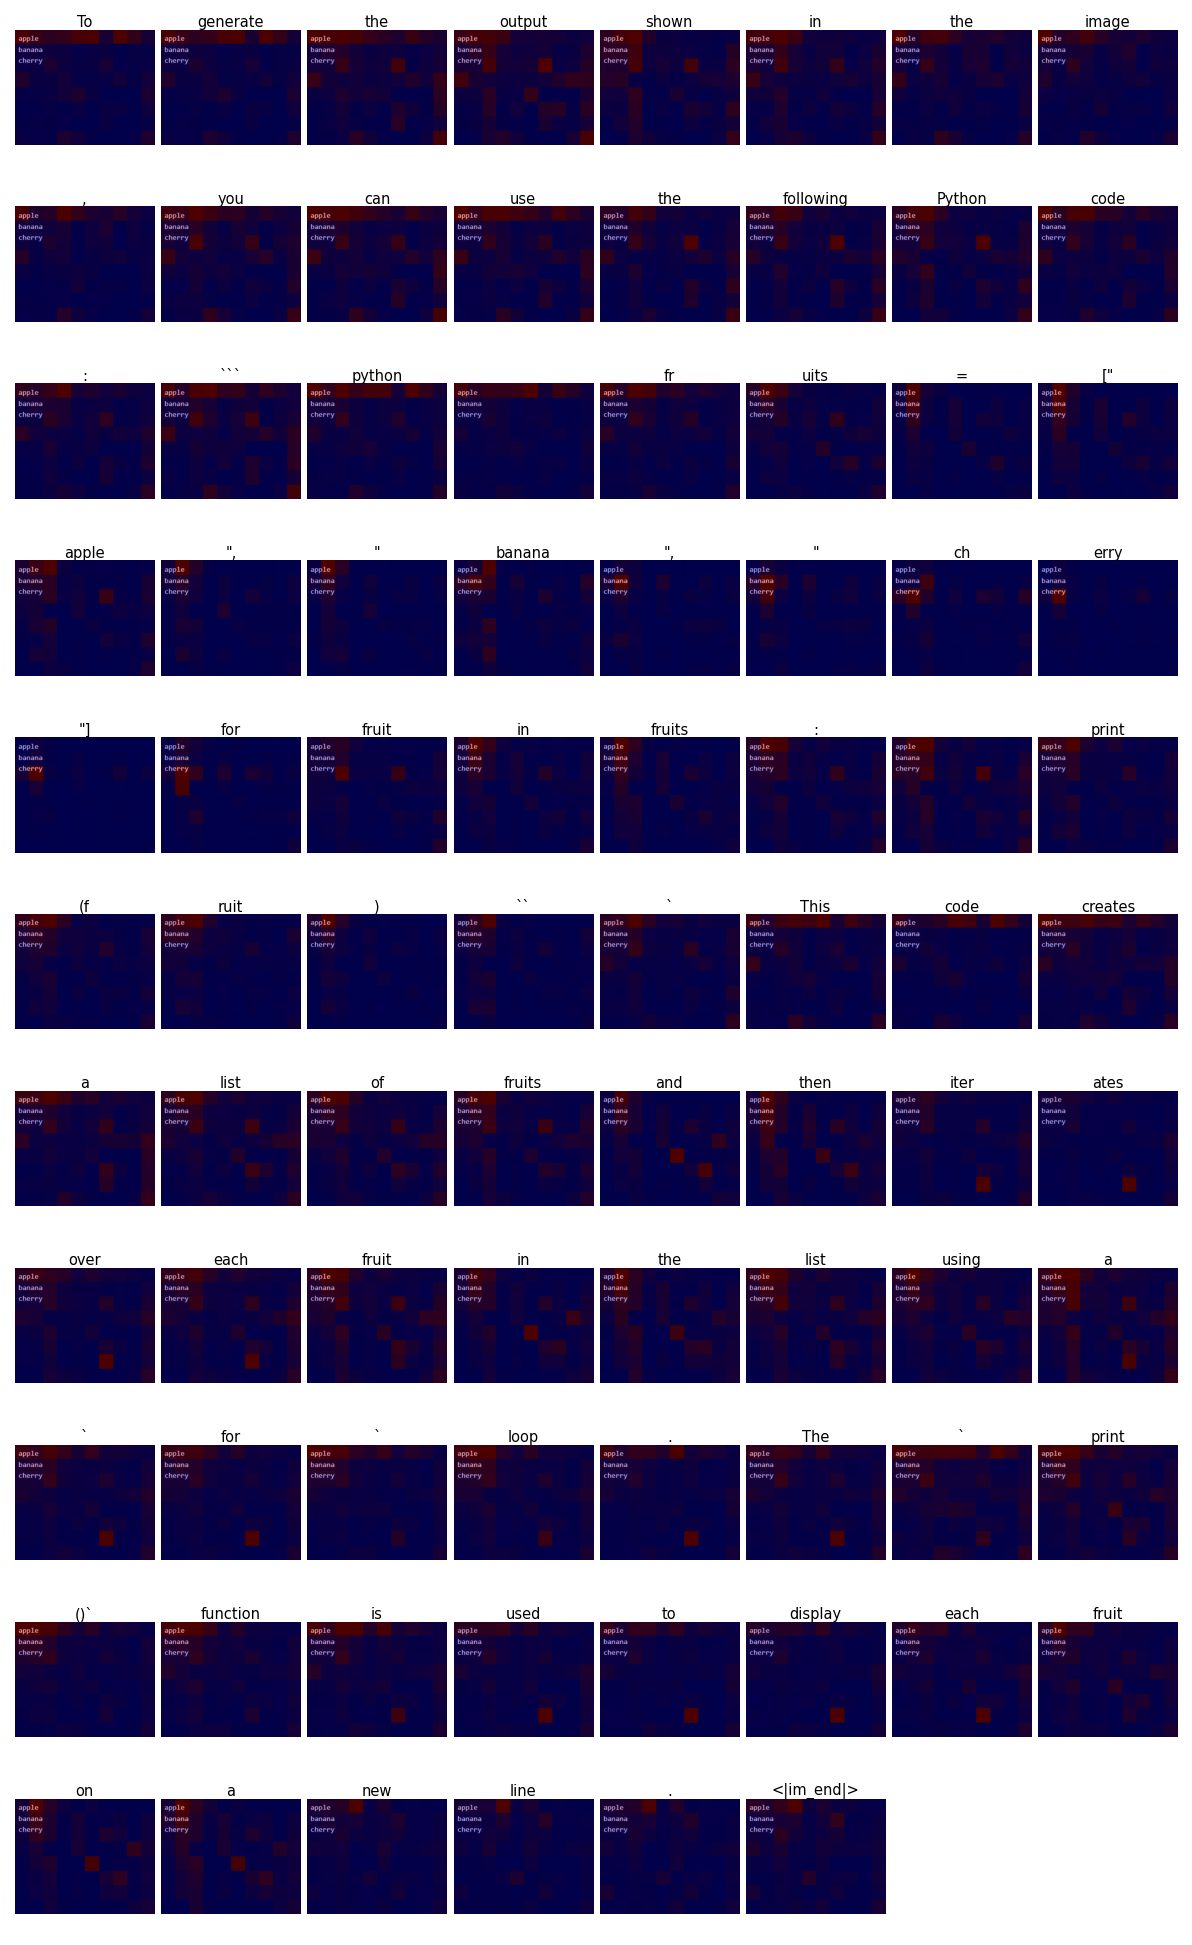

In [47]:
# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used
# vis_attn_matrix = aggregate_vit_attention(
#     model.get_vision_tower().image_attentions,
#     select_layer=-1,
#     all_prev_layers=True
# )   

# Looks like we can not get attention scores from the ViT...

num_image_per_row = 8
image_ratio = image.size[0] / image.size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row, 
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows), 
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or 
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    # -------------If somehow we can get the inner ViT attention, we can do this:-------------
    # attn_over_image = []
    # for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
    #     vis_attn = vis_attn.reshape(grid_size, grid_size)
    #     # vis_attn = vis_attn / vis_attn.max()
    #     attn_over_image.append(vis_attn * weight)
    # attn_over_image = attn_weights_over_vis_tokens
    # attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    # attn_over_image = attn_over_image / attn_over_image.max()
    # ----------------------------------------------------------------------------------------

    # Calculate attention to the processed visual tokens.
    token_img_shape = get_token_img_shape(image.size, patch_size=28)  # w, h
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens.reshape(1, 1, *token_img_shape[::-1])
    # Rescale the attentions scores to 0-1 for better visualization
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.max()
    
    attn_over_image = F.interpolate(
        attn_weights_over_vis_tokens, 
        size=image.size[::-1], # PyTorch wants (H, W)
        mode='nearest', 
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][len_prompt_tokens + i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off")

### Attention over the Image at a Specific Output Token

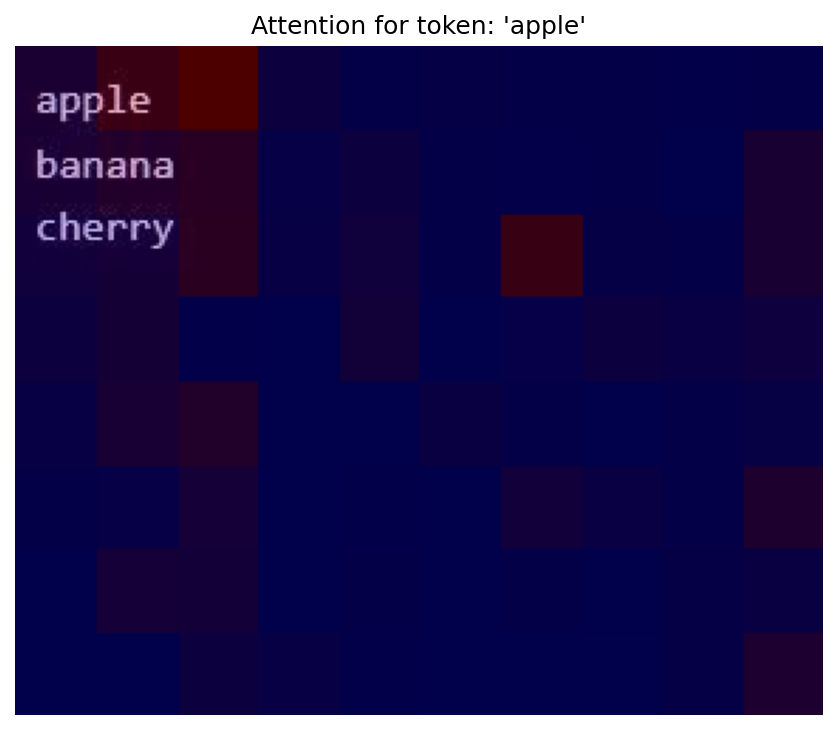

In [49]:
# --------Change the token offset here -----------
offset = 24
# ------------------------------------------------
# Define which output token you want to visualize
target_token_index = output_token_start + offset
target_token_str = tokenizer.decode(outputs["sequences"][0][target_token_index], add_special_tokens=False).strip()

# Get attention weights over vision tokens
attn_weights_over_vis_tokens = llm_attn_matrix[target_token_index][vision_token_start:vision_token_end]
attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

# Rescale the attentions scores to 0-1 for better visualization
attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.max()

# Resize attention to image dimensions
token_img_shape = get_token_img_shape(image.size, patch_size=28)
attn_weights_over_vis_tokens = attn_weights_over_vis_tokens.reshape(1, 1, *token_img_shape[::-1])
attn_over_image = F.interpolate(
    attn_weights_over_vis_tokens,
    size=image.size[::-1],  # (H, W)
    mode='nearest'
).squeeze()

# Create heatmap or overlay
np_img = np.array(image)[:, :, ::-1]
img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())

# Plot a large single image
fig, ax = plt.subplots(figsize=(6, 6 * (image.size[1] / image.size[0])), dpi=150)
ax.imshow(img_with_attn if vis_overlayed_with_attn else heatmap)
ax.set_title(f"Attention for token: '{target_token_str}'", fontsize=12)
ax.axis("off")
plt.tight_layout()
plt.show()
